In [18]:
import numpy as np
import torch
import pandas as pd
from kan import *
from collections import deque
!pip install ucimlrepo  --quiet
from IPython.utils import io
import numpy as np
from sklearn.decomposition import PCA

In [19]:
from ucimlrepo import fetch_ucirepo

# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697)

# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features
y = predict_students_dropout_and_academic_success.data.targets
# metadata 
metadata = predict_students_dropout_and_academic_success.metadata

# variable information 
variable_info = predict_students_dropout_and_academic_success.variables

df = X
df['Target'] = y

print(f"{df.shape[0]} entries with {df.shape[1]} features")
image_folder = "/Users/alexiy/Projects/Purdue/cs573_proj/kan_img"

4424 entries with 37 features


In [20]:
categorical_vars = {
    'Marital Status',
    'Application mode',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced', 'Educational special needs', 'Debtor',
    'Tuition fees up to date', 'Gender', 'Scholarship holder',
    'International',
    'Target'
}
quantitative_vars = {
   'Application order',
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
   'Curricular units 1st sem (enrolled)',
   'Curricular units 1st sem (credited)',
   'Curricular units 1st sem (evaluations)',
   'Curricular units 1st sem (approved)',
   'Curricular units 1st sem (grade)',
   'Curricular units 1st sem (without evaluations)',
   'Curricular units 2nd sem (credited)',
   'Curricular units 2nd sem (enrolled)',
   'Curricular units 2nd sem (evaluations)',
   'Curricular units 2nd sem (approved)',
   'Curricular units 2nd sem (grade)',
   'Curricular units 2nd sem (without evaluations)',
   'Unemployment rate',
   'Inflation rate',
    'GDP'
}
print("categorical vars", len(categorical_vars))
print("quantitative vars", len(quantitative_vars))
#print(df.columns)

categorical vars 18
quantitative vars 19


In [21]:
drop_features = set(["Father's qualification",
 'Gender',
 'Previous qualification (grade)',
 'International',
 'Curricular units 2nd sem (without evaluations)',
 'Marital Status',
 'GDP',
 'Displaced',
 'Debtor',
 'Inflation rate',
 "Mother's occupation",
 "Father's occupation",
 'Unemployment rate',
 'Previous qualification',
 'Curricular units 1st sem (without evaluations)',
 "Mother's qualification",
 'Curricular units 2nd sem (enrolled)',
 'Application order',
 'Age at enrollment',
 'Educational special needs','Nacionality'])

second_drop = set(['Curricular units 1st sem (grade)', 'Curricular units 1st sem (evaluations)'])

drop_features = drop_features.union(second_drop)

quantitative_vars -= drop_features
categorical_vars -= drop_features
df.drop(drop_features, axis=1, inplace=True)

df_encoded = df[df['Target'].isin(['Graduate', 'Dropout'])].copy()
df_encoded["Target"] = df_encoded["Target"].replace({'Graduate': 0, 'Dropout': 1})
# Applying one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=list(categorical_vars - {'Target'}))

# normalize quantitative columns:
df_encoded[list(quantitative_vars)] = df_encoded[list(quantitative_vars)].apply(lambda x: (x-x.min())/(x.max()-x.min()))

valid_count = int(len(df_encoded) * 0.7)
test_count = int(len(df_encoded) * 0.8)
df_shuffled = df_encoded.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_encoded[:valid_count].reset_index(drop=True)
df_valid = df_encoded[valid_count:test_count].reset_index(drop=True)
df_test = df_encoded[test_count:].reset_index(drop=True)

y_train = df_train["Target"]
x_train = df_train.drop(["Target"], axis=1)

y_test = df_test["Target"]
x_test = df_test.drop(["Target"], axis=1)

y_valid = df_valid["Target"]
x_valid = df_valid.drop(["Target"], axis=1)

print(f"train_ds: {df_train.shape[0]} samples")
print(f"test_ds: {df_test.shape[0]} samples")
print(f'[train_ds]: input shape: {x_train.shape}, output shape: {y_train.shape}')
print(f'[valid_ds]: input shape: {x_valid.shape}, valid shape: {y_valid.shape}')
print(f'[test_ds]: input shape: {x_test.shape}, output shape: {y_test.shape}')


train_ds: 2541 samples
test_ds: 726 samples
[train_ds]: input shape: (2541, 49), output shape: (2541,)
[valid_ds]: input shape: (363, 49), valid shape: (363,)
[test_ds]: input shape: (726, 49), output shape: (726,)


In [22]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [23]:
def prep_dataset(x_train, y_train, x_valid, y_valid, x_test, y_test):
    
    def get_dataloader(x, y, shuffle=False, batch_size=1):
        if not isinstance(x, np.ndarray):
            x = x.to_numpy()
        if not isinstance(y, np.ndarray):
            y = y.to_numpy()
        x, y = x.astype(np.float32), y.astype(np.int32)
        x = torch.from_numpy(x).to(torch.float32)
        y = torch.from_numpy(y).to(torch.long)
        ds = torch.utils.data.TensorDataset(x,y)
        return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle) 
    def get_ds_tensors(loader):
        x = torch.empty(0, x_train.shape[1], device=device)
        y = torch.empty(0, dtype=torch.long, device=device)
        for data, labels in loader:
            x = torch.cat((x, data.to(device)), dim=0)
            y = torch.cat((y, labels.to(device)), dim=0)
        return x, y
    
    x_train, y_train = get_ds_tensors(get_dataloader(x_train, y_train, shuffle=True))
    x_valid, y_valid = get_ds_tensors(get_dataloader(x_valid, y_valid, shuffle=False))
    
    train_ds = {}
    train_ds['train_input'] = x_train
    train_ds['test_input'] = x_valid 
    train_ds['train_label'] = y_train
    train_ds['test_label'] = y_valid
    if x_test is not None and y_test is not None:
        x_test, y_test = get_ds_tensors(get_dataloader(x_test, y_test, shuffle=False))
        test_ds = {}
        test_ds['test_input'] = x_test
        test_ds['test_label'] = y_test
        return train_ds, test_ds
    return train_ds, None

train_ds, test_ds = prep_dataset(x_train[:200], y_train[:200], x_valid[:200], y_valid[:200], x_test[:200], y_test[:200])

In [75]:
# model = KAN(width=[20,5,5,2], grid=3, k=3, seed=0)
# model = KAN(width=[10, 5, 2], grid=5, k=3, seed=0)
model = KAN(width=[10, 10, 2], grid=5, k=4, seed=0)
# model = KAN(width=[10, 6, 2], grid=6, k=6, seed=0)



checkpoint directory created: ./model
saving model version 0.0


In [76]:
all_train_acc = []
all_valid_acc = []
def train_acc():
    train_acc = torch.mean((torch.argmax(model(train_ds['train_input']), dim=1) == train_ds['train_label']).float())
    all_train_acc.append(train_acc.item())
    return train_acc

best_model = None
max_val_acc = 0
def test_acc():
    global best_model
    global max_val_acc
    valid_acc = torch.mean((torch.argmax(model(train_ds['test_input']), dim=1) == train_ds['test_label']).float())
    all_valid_acc.append(valid_acc.item())
    if valid_acc > max_val_acc:
        max_val_acc = valid_acc
        best_model = model.copy()
        print(f'saving model acc: {max_val_acc:.4f}')
    return valid_acc

results = model.fit(train_ds, opt="Adam", metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=200, lamb=0.02, lamb_entropy=10., save_fig=True, img_folder=image_folder)
best_model.saveckpt('./model/best')

| train_loss: 8.31e-01 | test_loss: 1.61e+00 | reg: 5.20e+01 | :   0%|      | 0/200 [00:00<?, ?it/s]

saving model acc: 0.3900


| train_loss: 1.59e+00 | test_loss: 2.49e+00 | reg: 3.69e+02 | :   0%| | 1/200 [00:05<18:27,  5.57s/

saving model acc: 0.4150


| train_loss: 2.24e+00 | test_loss: 3.15e+00 | reg: 3.75e+02 | :   1%| | 2/200 [00:11<18:28,  5.60s/

saving model acc: 0.5500


| train_loss: 3.18e+00 | test_loss: 1.11e+00 | reg: 4.18e+02 | :   2%| | 3/200 [00:16<18:25,  5.61s/

saving model acc: 0.6150


| train_loss: 1.18e+00 | test_loss: 1.24e+00 | reg: 4.57e+02 | :   2%| | 5/200 [00:27<18:06,  5.57s/

saving model acc: 0.7650


| train_loss: 3.09e+00 | test_loss: 3.04e+00 | reg: 6.47e+02 | :  10%| | 19/200 [02:28<19:03,  6.32s

saving model acc: 0.7950


| train_loss: 6.82e+00 | test_loss: 3.57e+00 | reg: 7.71e+02 | :  10%| | 21/200 [02:39<17:38,  5.91s

saving model acc: 0.8450


| train_loss: 3.48e+00 | test_loss: 3.34e+00 | reg: 7.09e+02 | :  11%| | 22/200 [02:44<16:59,  5.73s

saving model acc: 0.8650


| train_loss: 3.12e+00 | test_loss: 2.83e+00 | reg: 6.49e+02 | :  12%| | 24/200 [02:56<17:31,  5.97s

saving model acc: 0.8900


| train_loss: 6.60e-01 | test_loss: 6.01e-01 | reg: 1.30e+02 | : 100%|█| 200/200 [19:46<00:00,  5.93

saving model version 0.1


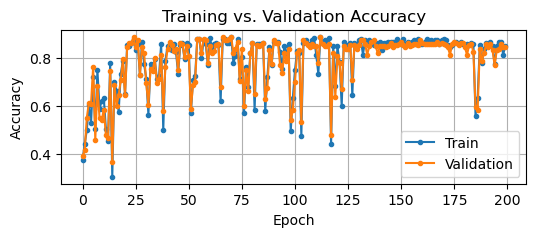

In [87]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 2))
plt.plot(range(len(all_train_acc)), all_train_acc, marker='.', label='Train')
plt.plot(range(len(all_valid_acc)), all_valid_acc, marker='.', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

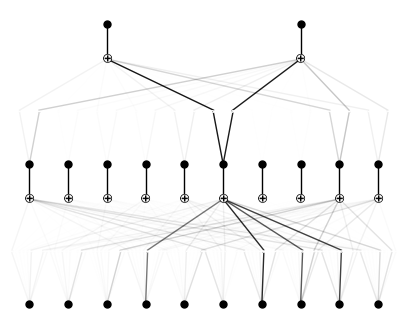

In [89]:
m =KAN.loadckpt('./model/best')
m.plot(scale=0.5)

# Parameter search

In [80]:
max_val_model_acc = torch.mean((torch.argmax(best_model(test_ds['test_input']), dim=1) == test_ds['test_label']).float()).item()
#max_val_model_acc = torch.mean((torch.argmax(m(test_ds['test_input']), dim=1) == test_ds['test_label']).float()).item()
max_epoch_model_acc = torch.mean((torch.argmax(model(test_ds['test_input']), dim=1) == test_ds['test_label']).float()).item()
print(f"max_test_model accuracy: {max_val_model_acc:.4f}")
print(f"max_epoch_model accuracy: {max_epoch_model_acc:.4f}")


max_test_model accuracy: 0.8250
max_epoch_model accuracy: 0.8000


# decreasing param 
caused increase in accuracy from 83% -> 86%

In [26]:
# subsampled k_folds - then will train
# will do k-fold cross validation on 500 datapoints with 5 splits
x_search, y_search = x_train[:500], y_train[:500]
x_splits = np.array_split(x_search, 5)
y_splits = np.array_split(y_search, 5)

cmp_count = 4
with io.capture_output() as captured:
    pca = PCA(n_components=cmp_count)
    pca.fit(x_train)

def get_ith_split(idx, pca_cmp=None):
    global x_splits, y_splits, pca, cmp_count 
    assert 0 <= idx <= 4

    train_ids = x_splits.copy()
    test_ids = train_ids[idx].copy()
    del train_ids[idx]
    train_ids = np.concatenate(train_ids, axis=0)
    
    train_labels = y_splits.copy()
    test_labels = train_labels[idx].copy()
    del train_labels[idx]
    train_labels = np.concatenate(train_labels, axis=0)
    
    out_train_ids = train_ids
    out_test_ids = test_ids
    
    if pca_cmp is not None:
        if pca_cmp != cmp_count:
            with io.capture_output() as _:
                pca = PCA(n_components=pca_cmp)
                pca.fit(x_train.copy())
            cmp_count = pca_cmp
        out_train_ids=pca.transform(train_ids.copy())
        out_test_ids=pca.transform(test_ids.copy())
        out_train_ids = (out_train_ids-np.min(out_train_ids))/(np.max(out_train_ids)-np.min(out_train_ids))
        out_test_ids = (out_test_ids-np.min(out_test_ids))/(np.max(out_test_ids)-np.min(out_test_ids))
    return prep_dataset(out_train_ids, train_labels, out_test_ids, test_labels, None, None)[0]
    

def get_max_model_acc(model, ds, steps=20, lamb=0.02, lamb_entropy=10):
    max_valid_acc = 0.
    def cv_train_acc():
        return torch.mean((torch.argmax(model(ds['train_input']), dim=1) == ds['train_label']).float())
    def cv_test_acc():
        nonlocal max_valid_acc
        valid_acc = torch.mean((torch.argmax(model(ds['test_input']), dim=1) == ds['test_label']).float())
        max_valid_acc = max(max_valid_acc, valid_acc.item())
        return valid_acc

    model.fit(train_ds, opt="Adam", metrics=(cv_train_acc, cv_test_acc),
                          loss_fn=torch.nn.CrossEntropyLoss(), steps=steps, lamb=lamb, lamb_entropy=lamb_entropy, save_fig=False, img_folder=image_folder)
    return max_valid_acc

# get_ith_split(0, 32)

In [40]:
# parameters to test:
EPOCHS = 20
LR = 0.2


#DEFAULT_ARCH = [10,5,2]
DEFAULT_ARCH = [10,10,2]
DEFAULT_GRID = 5
DEFAULT_DEGREE = 3

kan_grid = [i for i in range(2,11)]
kan_degree = [i for i in range(2,10)]
model_archs = [[10, 10, 2], [10,6,2],[5,5,2], [3,5,2], [10, 2, 2], [10, 5, 2], [20,5,2], [20,5,5,2],[3,3,2]]
# RUNNING PCA BREAKS bc destroy booleans
pca_components = [-1, 16, 32] #-1 is doing it with NONE

RUN_ARCH = True 
RUN_GRID = True 
RUN_DEGREE = True 
RUN_COMPOMENTS = True 

In [67]:
import warnings
warnings.filterwarnings("ignore")
def get_cross_validation_acc(model_arch=DEFAULT_ARCH, grid=DEFAULT_GRID, degree=DEFAULT_DEGREE, cmp=None):
    all_acc = []
    for i in range(5):
        ds = get_ith_split(i, pca_cmp=cmp)
        # print(ds['test_input'].shape)
        with io.capture_output() as _:
            model = KAN(width=model_arch, grid=grid, k=degree, seed=0)
        with io.capture_output() as _:
            max_acc = get_max_model_acc(model, ds, steps=EPOCHS, lamb=LR)
        all_acc.append(max_acc)
    all_acc = np.array(all_acc)

    return all_acc.mean(), all_acc.std()

if RUN_ARCH:
    print(10*"=", " RUNNING ARCHITECTURE ", 10*"=")
    model_arch_acc = []
    model_arch_ste = []
    for i, model_arch in enumerate(model_archs):
        acc, ste = get_cross_validation_acc (model_arch=model_arch.copy())
        print(f"[{i+1}/{len(model_archs)}] model arch: {tuple(model_arch)} acc: {acc:.4f}", end = '\n\r')
        model_arch_acc.append(acc)
        model_arch_ste.append(ste)
    print()
    np.save("model_arch.npy", np.array([[i for i in range(len(model_arch_acc))], model_arch_acc, model_arch_ste]))

if RUN_GRID:
    print(10*"=", " RUNNING GRID ", 10*"=")
    model_grid_acc = []
    model_grid_ste = []
    for i, grid in enumerate(kan_grid):
        acc, ste = get_cross_validation_acc(grid=grid)
        print(f"[{i+1}/{len(kan_grid)}] grid: {grid} acc: {acc:.4f}", end = '\n\r')
        model_grid_acc.append(acc)
        model_grid_ste.append(ste)
    print()
    np.save("model_grid.npy", np.array([kan_grid, model_grid_acc, model_grid_ste]))

if RUN_DEGREE:
    print(10*"=", " RUNNING DEGREE ", 10*"=")
    model_k_acc = []
    model_k_ste = []
    for i, k in enumerate(kan_degree):
        acc, ste = get_cross_validation_acc(degree=k)
        print(f"[{i+1}/{len((kan_degree))}] degree: {k} acc: {acc:.4f}", end='\n\r')
        model_k_acc.append(acc)
        model_k_ste.append(ste)
    print()
    np.save("model_degree.npy", np.array([kan_degree, model_k_acc,model_k_ste]))

if RUN_COMPOMENTS: 
    print(10*"=", " RUNNING COMPONENTS ", 10*"=")
    model_pca_acc = []
    model_pca_ste = []
    for i, cmp in enumerate(pca_components):
        if cmp == -1:
            acc, ste = get_cross_validation_acc()
        else:
            acc, ste = get_cross_validation_acc(cmp=cmp)
        print(f"[{i+1}/{len((pca_components))}] components: {cmp} acc: {acc:.4f}", end='\n\r')
        model_pca_acc.append(acc)
        model_pca_ste.append(ste)
    print()
    np.save("model_pca.npy", np.array([pca_components, model_pca_acc, model_pca_ste]))


==========  RUNNING ARCHITECTURE  ==========
[1/9] model arch: (10, 10, 2) acc: 0.8720
[2/9] model arch: (10, 6, 2) acc: 0.8160
[3/9] model arch: (5, 5, 2) acc: 0.7480
[4/9] model arch: (3, 5, 2) acc: 0.7040
[5/9] model arch: (10, 2, 2) acc: 0.8200
[6/9] model arch: (10, 5, 2) acc: 0.7460
[7/9] model arch: (20, 5, 2) acc: 0.7720
[8/9] model arch: (20, 5, 5, 2) acc: 0.6800
[9/9] model arch: (3, 3, 2) acc: 0.7020

==========  RUNNING GRID  ==========
[1/9] grid: 2 acc: 0.6900
[2/9] grid: 3 acc: 0.7300
[3/9] grid: 4 acc: 0.6900
[4/9] grid: 5 acc: 0.8720
[5/9] grid: 6 acc: 0.8700
[6/9] grid: 7 acc: 0.8540
[7/9] grid: 8 acc: 0.8180
[8/9] grid: 9 acc: 0.8100
[9/9] grid: 10 acc: 0.8260

==========  RUNNING DEGREE  ==========
[1/8] degree: 2 acc: 0.8260
[2/8] degree: 3 acc: 0.8720
[3/8] degree: 4 acc: 0.8760
[4/8] degree: 5 acc: 0.7840
[5/8] degree: 6 acc: 0.8440
[6/8] degree: 7 acc: 0.8420
[7/8] degree: 8 acc: 0.8600
[8/8] degree: 9 acc: 0.8580

==========  RUNNING COMPONENTS  ==========
[1/3

In [68]:
model_arch_res = np.load('model_arch.npy')
model_degree_res = np.load('model_degree.npy')
model_grid_res = np.load('model_grid.npy')
model_pca_res = np.load('model_pca.npy')

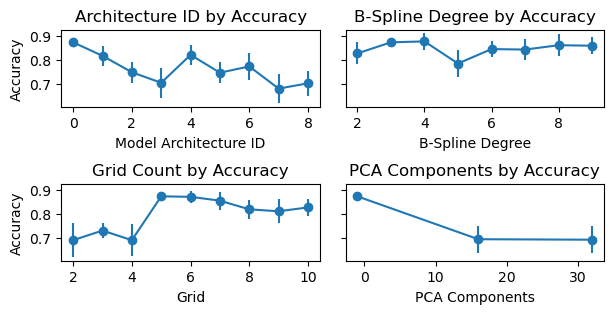

In [74]:
import numpy as np
import matplotlib.pyplot as plt
def plot_data(x,y,title, x_l, y_l):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o')
    plt.xlabel(x_l)
    plt.ylabel(y_l)
    plt.title(title)
    plt.grid(True)
    plt.show()

fig, ax = plt.subplots(2,2, figsize=(7,3),sharey=True)
plt.subplots_adjust(hspace=0.2) 
ax[0,0].set_title("Architecture ID by Accuracy")
ax[0,0].errorbar(model_arch_res[0,:], model_arch_res[1,:], yerr=model_arch_res[2,:], fmt='-o')
ax[0,0].set_xlabel("Model Architecture ID")
ax[0,0].set_ylabel("Accuracy")

ax[0,1].set_title("B-Spline Degree by Accuracy")
ax[0,1].errorbar(model_degree_res[0,:], model_degree_res[1,:], yerr=model_degree_res[2,:], fmt='-o')
ax[0,1].set_xlabel("B-Spline Degree")
#ax[0,1].set_ylabel("Accuracy")

ax[1,0].set_title("Grid Count by Accuracy")
ax[1,0].errorbar(model_grid_res[0,:], model_grid_res[1,:], yerr=model_grid_res[2,:], fmt='-o')
ax[1,0].set_xlabel("Grid")
ax[1,0].set_ylabel("Accuracy")

ax[1,1].set_title("PCA Components by Accuracy")
ax[1,1].errorbar(model_pca_res[0,:], model_pca_res[1,:], yerr=model_pca_res[2,:], fmt='-o')
ax[1,1].set_xlabel("PCA Components")
plt.subplots_adjust(hspace=1)
plt.subplots_adjust(wspace=0.1)
#ax[1,1].set_ylabel("Accuracy")


# plot_data(x=model_arch_res[0,:], y = model_arch_res[1,:], x_l='KAN Architecture ID', y_l='Validation Accuracy', title="Validation Accuracy vs KAN Architecture")
# plot_data(x=model_degree_res[0,:], y = model_degree_res[1,:], x_l='KAN Degree', y_l='Validation Accuracy', title="Validation Accuracy vs KAN Degree")
# plot_data(x=model_grid_res[0,:], y = model_grid_res[1,:], x_l='KAN Grid', y_l='Validation Accuracy', title="Validation Accuracy vs KAN Grid")
# plot_data(x=model_pca_res[0,:], y = model_pca_res[1,:], x_l='PCA Components', y_l='Validation Accuracy', title="Validation Accuracy vs PCA Components")



In [ ]:
components = [4, 8, 16, 24, 32, 48, 64, 78, 96, 104, 128]
var_ratio = []
for cmp_count in components:
    with io.capture_output() as captured:
        pca = PCA(n_components=cmp_count)
        pca.fit(x_train)
        var_ratio.append(np.sum(pca.explained_variance_ratio_))
plt.figure(figsize=(8,4))
plt.grid()
plt.plot(components,var_ratio,marker='o')
plt.xlabel('Component Count')
plt.ylabel('Explained Variance Ratio')
plt.title('Component Count vs Explained Variance Ratio');